In [17]:
import json
import pandas as pd
import seaborn as sns
import numpy as np

MAX_ITEMS=5 #Number of ranked items to be returned, changeable:)
PASSAGES=4000 #Number of passages used , fixed:(
QUERIES=280 #Number of queries made against these passages, fixed:(

### Loading Data

In [18]:
filepath='/content/drive/MyDrive/Zevi_search_dataset.json'

with open(filepath) as f:
  data = json.load(f)


In [19]:
df=pd.DataFrame(data)
df.head(10)

,name,description,brand,categories,hierarchicalCategories,type,price,price_range,image,url,free_shipping,rating,popularity,objectID
0,Amazon - Fire TV Stick with Alexa Voice Remote...,"Enjoy smart access to videos, games and apps w...",Amazon,"[TV & Home Theater, Streaming Media Players]","{'lvl0': 'TV & Home Theater', 'lvl1': 'TV & Ho...",Streaming media plyr,39.99,1 - 50,https://cdn-demo.algolia.com/bestbuy-0118/5477...,https://api.bestbuy.com/click/-/5477500/pdp,False,4,21469,5477500
1,Google - Chromecast - Black,Google Chromecast: Enjoy a world of entertainm...,Google,"[TV & Home Theater, Streaming Media Players]","{'lvl0': 'TV & Home Theater', 'lvl1': 'TV & Ho...",Streaming media plyr,35.00,1 - 50,https://cdn-demo.algolia.com/bestbuy-0118/4397...,https://api.bestbuy.com/click/-/4397400/pdp,False,4,21468,4397400
2,"Dell - Inspiron 15.6"" Touch-Screen Laptop - In...",Dell Inspiron Laptop: Get speed and performanc...,Dell,"[Computers & Tablets, Laptops]","{'lvl0': 'Computers & Tablets', 'lvl1': 'Compu...",Burst skus,499.99,200 - 500,https://cdn-demo.algolia.com/bestbuy-0118/5588...,https://api.bestbuy.com/click/-/5588602/pdp,True,4,21467,5588602
3,Amazon - Echo Dot,Deliver your favorite playlist anywhere in you...,Amazon,[Smart Home],{'lvl0': 'Smart Home'},Voice assistants,49.99,1 - 50,https://cdn-demo.algolia.com/bestbuy-0118/5578...,https://api.bestbuy.com/click/-/5578851/pdp,True,4,21466,5578851
4,"Apple - MacBook Air® (Latest Model) - 13.3"" Di...","MacBook Air features up to 8GB of memory, a fi...",Apple,"[Computers & Tablets, Laptops, All Laptops, Ma...","{'lvl0': 'Computers & Tablets', 'lvl1': 'Compu...",Apple,999.99,500 - 2000,https://cdn-demo.algolia.com/bestbuy-0118/6443...,https://api.bestbuy.com/click/-/6443034/pdp,True,4,21465,6443034
5,"Sharp - 50"" Class (49.5"" Diag.) - LED - 1080p ...",Only at Best Buy Sharp LC-50LB481U LED Roku T...,Sharp,"[TV & Home Theater, TVs, All Flat-Panel TVs]","{'lvl0': 'TV & Home Theater', 'lvl1': 'TV & Ho...","45""-50"" tv's",429.99,200 - 500,https://cdn-demo.algolia.com/bestbuy-0118/4863...,https://api.bestbuy.com/click/-/4863102/pdp,False,4,21464,4863102
6,Google - Google Home - White/Slate fabric,Simplify your everyday life with the Google Ho...,Google,[Smart Home],{'lvl0': 'Smart Home'},Voice assistants,129.00,100 - 200,https://cdn-demo.algolia.com/bestbuy-0118/5578...,https://api.bestbuy.com/click/-/5578849/pdp,True,4,21463,5578849
7,Apple - EarPods™ with Remote and Mic - White,"Control media playback, adjust the volume and ...",Apple,"[Audio, Headphones, All Headphones]","{'lvl0': 'Audio', 'lvl1': 'Audio > Headphones'...",Earbud headphones,29.99,1 - 50,https://cdn-demo.algolia.com/bestbuy-0118/6848...,https://api.bestbuy.com/click/-/6848136/pdp,True,4,21462,6848136
8,Philips - hue A19 Smart LED Light Bulb - White...,Philips hue A19 Smart LED Light Bulb: Get ligh...,Philips,"[Smart Home, Smart Lighting, Smart Light Bulbs]","{'lvl0': 'Smart Home', 'lvl1': 'Smart Home > S...",Smart lighting,14.99,1 - 50,https://cdn-demo.algolia.com/bestbuy-0118/4374...,https://api.bestbuy.com/click/-/4374300/pdp,False,4,21461,4374300
9,Nintendo - amiibo Figure (The Legend of Zelda:...,"Zelda appears here carrying a Sheikah Slate, a...",Nintendo,"[Video Games, Toys to Life, Amiibo]","{'lvl0': 'Video Games', 'lvl1': 'Video Games >...",Toy 2 life character,15.99,1 - 50,https://cdn-demo.algolia.com/bestbuy-0118/5723...,https://api.bestbuy.com/click/-/5723538/pdp,False,0,21460,5723538


In [20]:
df['description'][0]

'Enjoy smart access to videos, games and apps with this Amazon Fire TV stick. Its Alexa voice remote lets you deliver hands-free commands when you want to watch television or engage with other applications. With a quad-core processor, 1GB internal memory and 8GB of storage, this portable Amazon Fire TV stick works fast for buffer-free streaming.'

In [21]:
df['image'][0]

'https://cdn-demo.algolia.com/bestbuy-0118/5477500_sb.jpg'

## EDA
 Analyzing the distributions of numerical and counts of categorical features. Except for image and object Id colums.

In [22]:
df.columns

Index(['name', 'description', 'brand', 'categories', 'hierarchicalCategories',
       'type', 'price', 'price_range', 'image', 'url', 'free_shipping',
       'rating', 'popularity', 'objectID'],
      dtype='object')

In [23]:
df.loc[932,['name','brand']]

name     Panasonic - KX-TGL463S Linc2Cell DECT 6.0 Expa...
brand                                            Panasonic
Name: 932, dtype: object

**Analysis**
Name of the brand is concatenated with the name of the product with a trailing dash, and for now we will keep both brand name field seperately and brand appended with product name.

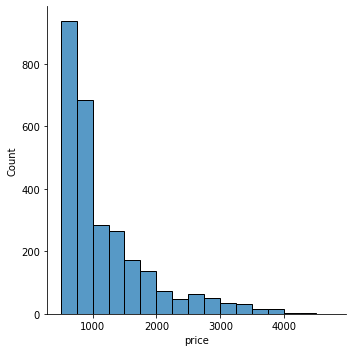

In [24]:
#Get distribution of price of products
sns.displot(df, x='price',bins=list(np.arange(500,5000,250)));


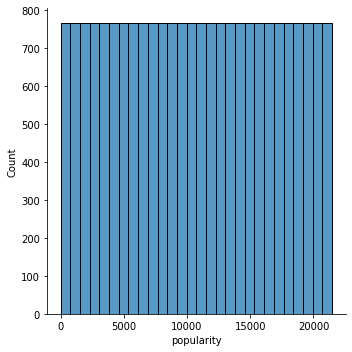

In [25]:
#Get distribution of popularity of products
sns.displot(df, x='popularity');


The popularity feature is simply incremental for each product, where the first product has highest value for popularity i.e. number of products and the last product has least value of popularity i.e. 1. We are gonna encode this feature as a sentence too, for answering queries relevant to order of items / popularity in data.

In [26]:
df['price_range'].unique()

array(['1 - 50', '200 - 500', '500 - 2000', '100 - 200', '50 - 100',
       '> 2000'], dtype=object)

**Analysis**
Price Range seems to be not much of a useful feature, as the exact price is already given, but we are gonna encode exact price information and price range into a single sentence for the passage.

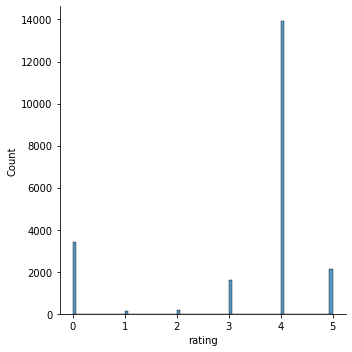

In [27]:
#Get distribution of rating of products
sns.displot(df, x='rating');


**Analysis**
Most of the products are ranked at a rating of 4, whereas very few products have a rating less than 3. Ratings can help answer queries including the information about the sentiment of the user towards product. Each rating value can be associated with an ordinal sentiment category.

In [28]:
x=df['brand'].value_counts()

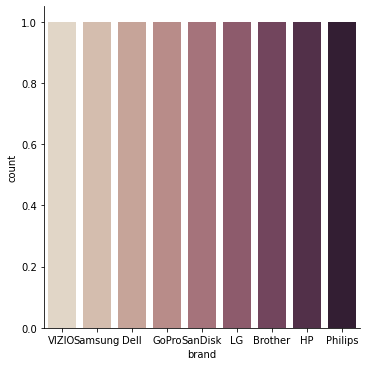

In [29]:
brand_df=pd.DataFrame(df.loc[x[x>300],'brand'],columns=['brand'])
sns.catplot(x="brand", kind="count", palette="ch:.25", data=brand_df);


In [30]:
df['type'].value_counts()

                            10810
Trend cases                   457
Ult protection cases          393
Ink cartridges                249
Business cases                217
                            ...  
At&#38;t broadband hw           1
T-m iphone handset              1
Security&#38;maintenance        1
Hello kitty                     1
Sprint prepaid                  1
Name: type, Length: 403, dtype: int64

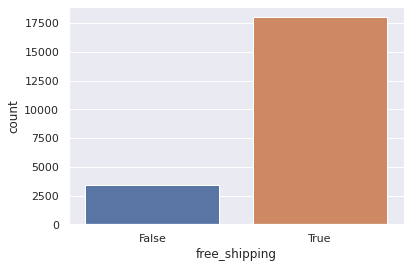

In [31]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="free_shipping", data=df)

In [32]:
#Percent of products with free shipping
df.loc[df['free_shipping']==True,'free_shipping'].count()/df.shape[0]

0.8390237086031022

**Analysis**
Almost 83% products have free shipping and remaining have shiiping charges. Query involving free shipping requests can help filter these products, if I include free_shipping as a sentence in passage.

In [33]:
df['hierarchicalCategories'][30]

{'lvl0': 'Name Brands',
 'lvl1': 'Name Brands > GoPro',
 'lvl2': 'Name Brands > GoPro > GoPro Cameras'}

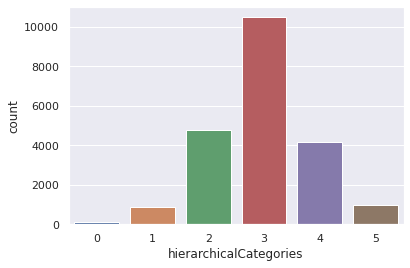

In [34]:
category_lengths=pd.DataFrame(df['hierarchicalCategories'].apply(lambda x: len(x)))
ax = sns.countplot(x="hierarchicalCategories", data=category_lengths)

**Analysis**
Each heirarchichal category have atmost three levels of categories it belongs to, where ever preeceding level is a sub level of the previous category. Most of the products have 3 categorical levels, whereas last categorical level contains infor about all the levels and hence can be used for encoding information about heirarchical categoires in passage.

In [35]:
df['categories'][13]

['TV & Home Theater', 'TV Mounts']

In [36]:
df['hierarchicalCategories'][13]

{'lvl0': 'TV & Home Theater', 'lvl1': 'TV & Home Theater > TV Mounts'}

**Analysis**
We will encode information from heirarchical categories into a passage from last level, as it encodes information about order and related categoires of a product.


In [37]:
df.columns

Index(['name', 'description', 'brand', 'categories', 'hierarchicalCategories',
       'type', 'price', 'price_range', 'image', 'url', 'free_shipping',
       'rating', 'popularity', 'objectID'],
      dtype='object')

In [38]:
#Missing Values
df.isnull().sum()

name                      0
description               0
brand                     0
categories                0
hierarchicalCategories    0
type                      0
price                     0
price_range               0
image                     0
url                       1
free_shipping             0
rating                    0
popularity                0
objectID                  0
dtype: int64

In [39]:
df.loc[df['url'].isnull(),'url']='<NoURL>'


In [40]:
#Missing Values
df.isnull().sum()

name                      0
description               0
brand                     0
categories                0
hierarchicalCategories    0
type                      0
price                     0
price_range               0
image                     0
url                       0
free_shipping             0
rating                    0
popularity                0
objectID                  0
dtype: int64

**Analysis**
There are no missing vlaues in this dataframe execpt for one sample's url, which is great.

**Conclusion EDA**

There is alot of other questoins that can be asked form data, but contextual encoding of the passage and query is expected to answer all those questions automatically, while attention based searching. Some of the questions include:
1. What are the products one can get from a particular category in given price range with free shipping?
2. What is the price range of top rated products? What are the cheapest top rated products?
3. Which category have largest description?
4. What is the difference between price of products with free shipping  and shipping charges?
5. For a particular category which brands offers the cheapest top rated products?


## Data Preprocessing
For treating this problem as an open ended contextual QnA problem, we need to transform each sample into a document index aka a passage and append it to description. 


### **Passage Creation**
For that we transform each feature or attribute into a sentence, except for object Id and missing features.
All features seems good candidate for feature creation. We are not dropping the url, objectID and popularity column either and including it as a sentence in the passage, for answering the queries related to these features.


In [41]:
df.columns

Index(['name', 'description', 'brand', 'categories', 'hierarchicalCategories',
       'type', 'price', 'price_range', 'image', 'url', 'free_shipping',
       'rating', 'popularity', 'objectID'],
      dtype='object')

In [42]:
#Function for converting each record to a passage.
#Args: One record from dataframe df.iloc[0]
#Returns:  Passage corresponding to input record
def make_passage(product):
  #Result passage object to return
  psg=''

  #Trsform name column to sentence
  psg+='The product is called '+product['name']+'.'

  #Brand
  psg+='It is made by '+product['brand']+'. '

  #Append description to it
  psg+=product['description']

  #Append type
  if product['type']:
    psg+='It is a '+product['type']+'. '

  #Append price and price range
  psg+='It falls in price range of '+ str(product['price_range']) + ' and is of '+ str(product['price'])+ ' dollars.'

  #Append heirarchical category
  if(len(product['hierarchicalCategories'])>0):
    cat_lvls=product['hierarchicalCategories'][list(product['hierarchicalCategories'])[-1]].split('>')
    psg+='It belongs to '+cat_lvls[0]
    for lvl in cat_lvls[1:]:
      psg+=' and it\'s sub category '+lvl

  #Free shipping
  if product['free_shipping']:
    psg+='. It has free shipping.'
  else:
    psg+='. It does not have free shipping.'
  
  #Rating and popularity
  psg+='It has a rating of '+ str(product['rating'])+' and a popularity index of '+str(product['popularity'])+'.'

  #Product id, url and image
  psg+=' The object id of the product is '+product['objectID']+'. Image is avaible on '+product['image']+' and more detials can be found on '+product['url'] +'.'

  return psg


In [43]:
make_passage(df.iloc[0])

"The product is called Amazon - Fire TV Stick with Alexa Voice Remote - Black.It is made by Amazon. Enjoy smart access to videos, games and apps with this Amazon Fire TV stick. Its Alexa voice remote lets you deliver hands-free commands when you want to watch television or engage with other applications. With a quad-core processor, 1GB internal memory and 8GB of storage, this portable Amazon Fire TV stick works fast for buffer-free streaming.It is a Streaming media plyr. It falls in price range of 1 - 50 and is of 39.99 dollars.It belongs to TV & Home Theater  and it's sub category  Streaming Media Players. It does not have free shipping.It has a rating of 4 and a popularity index of 21469. The object id of the product is 5477500. Image is avaible on https://cdn-demo.algolia.com/bestbuy-0118/5477500_sb.jpg and more detials can be found on https://api.bestbuy.com/click/-/5477500/pdp."

In [44]:
passages=df.apply(make_passage,axis=1)
passages.head()

0    The product is called Amazon - Fire TV Stick w...
1    The product is called Google - Chromecast - Bl...
2    The product is called Dell - Inspiron 15.6" To...
3    The product is called Amazon - Echo Dot.It is ...
4    The product is called Apple - MacBook Air® (La...
dtype: object

In [45]:
passages[0]

"The product is called Amazon - Fire TV Stick with Alexa Voice Remote - Black.It is made by Amazon. Enjoy smart access to videos, games and apps with this Amazon Fire TV stick. Its Alexa voice remote lets you deliver hands-free commands when you want to watch television or engage with other applications. With a quad-core processor, 1GB internal memory and 8GB of storage, this portable Amazon Fire TV stick works fast for buffer-free streaming.It is a Streaming media plyr. It falls in price range of 1 - 50 and is of 39.99 dollars.It belongs to TV & Home Theater  and it's sub category  Streaming Media Players. It does not have free shipping.It has a rating of 4 and a popularity index of 21469. The object id of the product is 5477500. Image is avaible on https://cdn-demo.algolia.com/bestbuy-0118/5477500_sb.jpg and more detials can be found on https://api.bestbuy.com/click/-/5477500/pdp."

In [46]:
#Make a dataframe of passages with passage id
passages=pd.DataFrame(passages,columns=['passage'])
#Sampling 4000 random passages subset without replacement
p_sset=passages.sample(n=PASSAGESb)

p_sset['psg_id']=list(range(0,p_sset.shape[0]))
p_sset.head()

NameError: ignored

In [ ]:
p_sset.to_excel('test.xlsx',index=False)

Creating a passages dataframe, with all the documents and a unique passage id to map it to relevant queries.

### **Query Creation**
Next up we need to create some queries, to deal with it as a supervised learning problem. Using the structure of information retrieval data from Kaggle by the Allen Institute of A.I, [linked here](https://www.kaggle.com/dmaso01dsta/cisi-a-dataset-for-information-retrieval?select=CISI.REL). As per reference dataset, the number of queries that we need to have, should be 7% of the number of avaible documents. We have 21469 passages / documents and this employes we need 1503 queries to evaluate the performance of our informtion retrieval model. Making this much queries is a little harder and more time consuming, so we will use a smaller portion of our data to evaluate the model's performance and will add more queries and documents to improve model's performance, if needed, keeping the ration of 7% intact between number of queries and passages.<br>
Using only 4000 samples for first round with 280 queries.

In [ ]:
for p in p_sset['passage']:
  if 'free' in p:
    print(p)
    break;       

In [ ]:
acoisndc;aoIZNcaoi;sdc coimsA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')